In [1]:
!pip install gymnasium
!pip install renderlab

Unable to create process using 'C:\Users\Nicholas Vella\anaconda3\python.exe "C:\Users\Nicholas Vella\anaconda3\Scripts\pip-script.py" install gymnasium'
Unable to create process using 'C:\Users\Nicholas Vella\anaconda3\python.exe "C:\Users\Nicholas Vella\anaconda3\Scripts\pip-script.py" install renderlab'


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")


In [3]:
GAMMA = 0.99
BATCH_SIZE = 32  # Decrease batch size
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TARGET_UPDATE_FREQ = 5



In [4]:
env = gym.make("LunarLander-v2", render_mode = "rgb_array")
obs = env.reset()
episode_reward = 0.0

In [5]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [6]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [7]:
from torch.nn.init import  uniform_
import math

class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()

        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))

        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        nn.init.constant_(self.w_sigma, 0.017)
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=0.5):  # Adjust sigma
        if self.training:
            w_noise = torch.normal(0, sigma, size=self.w_mu.size())
            b_noise = torch.normal(0, sigma, size=self.b_mu.size())
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            return F.linear(x, self.w_mu, self.b_mu)


In [8]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = NoisyLinear(ninputs, 128)
        self.a2 = NoisyLinear(128, 64)
        self.a3 = NoisyLinear(64, noutputs)  # Add an additional hidden layer

    def forward(self, X):
        o = self.a1(X)
        o = torch.relu(o)  # Add ReLU activation function
        o = self.a2(o)
        o = torch.tanh(o)  # You can add activation functions between layers if needed
        o = self.a3(o)
        return o

    def __call__(self, X):
        return self.forward(X)


In [9]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_policy.train()
dqn_target.eval()

DQN(
  (a1): NoisyLinear()
  (a2): NoisyLinear()
  (a3): NoisyLinear()
)

In [10]:
loss_fn = nn.MSELoss()

learning_rate = 0.0005    # Experiment with different learning rates
optimizer = torch.optim.RMSprop(dqn_policy.parameters(), lr=learning_rate)


## Training

In [11]:
obs, _ = env.reset()
episode = 1
all_rewards = []
all_episodes = []

for step in itertools.count():
    action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        replay_memory.rewards.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)
        all_rewards.append(avg_res)
        all_episodes.append(episode)
        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())

Episode: 100 Avg Results: -105.3851081416409
Episode: 200 Avg Results: -11.388415681460335
Episode: 300 Avg Results: 103.84232263989304
Episode: 400 Avg Results: 171.67391680928984
Episode: 500 Avg Results: 83.81656649768311
Episode: 600 Avg Results: 122.96249712073373
Episode: 700 Avg Results: 108.19326667725473
Episode: 800 Avg Results: 100.46977777811651
Solved at episode: 841 Avg Results: 196.2149154521473


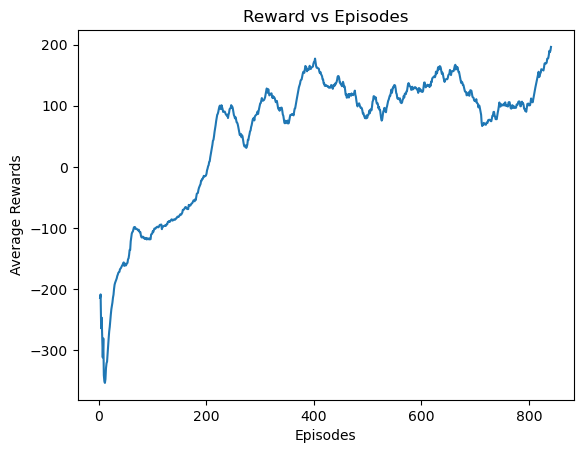

In [12]:
# Plot the returns versus trained episodes
plt.plot(all_episodes, all_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Reward vs Episodes')
plt.show()